# Using information theory to evaluate features

The mutual information (MI) between a feature and the outcome is a measure of the mutual dependence between the two variables. It extends the notion of correlation to nonlinear relationships. More specifically, it quantifies the information obtained about one random variable through the other random variable.

The concept of MI is closely related to the fundamental notion of entropy of a random variable. Entropy quantifies the amount of information contained in a random variable. Formally, the mutual information—I(X, Y)—of two random variables, X and Y, is defined as the following:

The sklearn function implements feature_selection.mutual_info_regression that computes the mutual information between all features and a continuous outcome to select the features that are most likely to contain predictive information. There is also a classification version (see the documentation for more details).

This notebook contains an application to the financial data we created in Chapter 4, Alpha Factor Research.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We use the data produced in [Chapter 4](../../04_alpha_factor_research/00_data/feature_engineering.ipynb).

In [1]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'assets.h5')

In [7]:
with pd.HDFStore(HDF_PATH) as store:
    data = store['engineered_features']

## Create Dummy variables

In [10]:
# Create dummy variables for categorical columns
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
# Remove '.0' from column names (cleaning up float-to-string conversion artifacts)
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
# Print information about the dummy_data DataFrame
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 277566 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 87 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   return_1m               277566 non-null  float64
 1   return_2m               277566 non-null  float64
 2   return_3m               277566 non-null  float64
 3   return_6m               277566 non-null  float64
 4   return_9m               277566 non-null  float64
 5   return_12m              277566 non-null  float64
 6   Mkt-RF                  277566 non-null  float64
 7   SMB                     277566 non-null  float64
 8   HML                     277566 non-null  float64
 9   RMW                     277566 non-null  float64
 10  CMA                     277566 non-null  float64
 11  momentum_2              277566 non-null  float64
 12  momentum_3              277566 non-null  float64
 13  

In [11]:
# Define target labels for different time horizons
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
# Extract target columns from the data
targets = data.dropna().loc[:, target_labels]

# Create features DataFrame by dropping target columns
features = data.dropna().drop(target_labels, axis=1)
# Convert 'sector' column to numeric codes
features.sector = pd.factorize(features.sector)[0]

# Define categorical columns
cat_cols = ['year', 'month', 'msize', 'age', 'sector']
# Get indices of categorical columns in the features DataFrame
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

# Initialize DataFrame to store mutual information
mutual_info = pd.DataFrame()
for label in target_labels:
    # Calculate mutual information between each feature and the target
    mi = mutual_info_classif(X=features,
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    # Store results in the mutual_info DataFrame
    mutual_info[label] = pd.Series(mi, index=features.columns)

# Sum up mutual information scores for each target
mutual_info.sum()

,0
target_1m,0.041184
target_2m,0.068973
target_3m,0.099923
target_6m,0.145159
target_12m,0.215051


## Normalized MI Heatmap

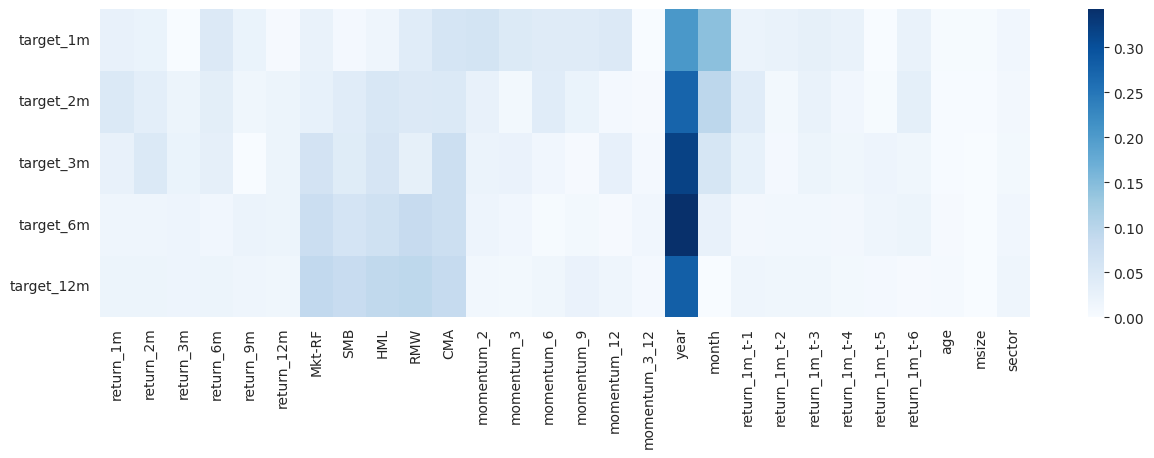

In [12]:
# Create a figure and axis for the plot
fig, ax= plt.subplots(figsize=(15, 4))
# Create a heatmap of normalized mutual information scores
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

## Dummy Data

In [13]:
# Redefine target labels
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
# Extract target columns from dummy_data
dummy_targets = dummy_data.dropna().loc[:, target_labels]

# Create dummy_features DataFrame by dropping target columns
dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
# Identify new categorical columns created by get_dummies
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

# Initialize DataFrame to store mutual information for dummy variables
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    # Calculate mutual information for dummy variables
    mi = mutual_info_classif(X=dummy_features,
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    # Store results in the mutual_info_dummies DataFrame
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

# Sum up mutual information scores for dummy variables
mutual_info_dummies.sum()

,0
target_1m,0.042399
target_2m,0.070975
target_3m,0.102736
target_6m,0.149333
target_12m,0.220179


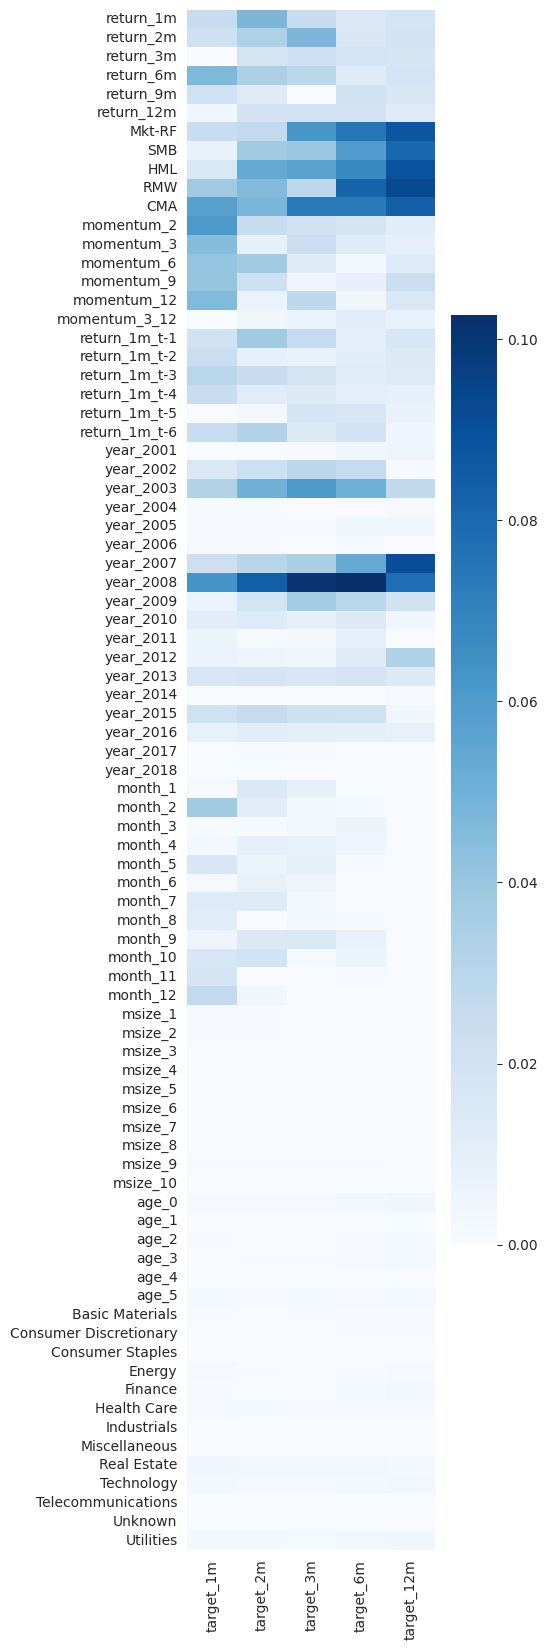

In [14]:
# Create a figure and axis for the plot
fig, ax= plt.subplots(figsize=(4, 20))
# Create a heatmap of normalized mutual information scores for dummy variables
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');